<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Abstarctive_Text_Summarization_using_Simple_T5_Transformer_custom_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plabannayak","key":"f1f19a1783935d871fc0049a716ef3a8"}'}

In [2]:
!mkdir -p ~/.kaggle                                               
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d sunnysai12345/news-summary

 51% 10.0M/19.8M [00:00<00:00, 31.3MB/s]
100% 19.8M/19.8M [00:00<00:00, 52.3MB/s]


In [4]:
!mkdir Data
!unzip "/content/news-summary.zip" -d "/content/Data"

Archive:  /content/news-summary.zip
  inflating: /content/Data/news_summary.csv  
  inflating: /content/Data/news_summary_more.csv  


## Simplet5

In [19]:
!pip install -q simplet5

## import libraries

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_csv("/content/Data/news_summary.csv",encoding='latin-1',usecols=['headlines','text'])

In [3]:
df.head()

,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...


## T5 data preparation with Training Data Column Names - source_text and target_text

In [4]:
df = df.rename(columns={'headlines':'target_text','text':'source_text'}) #source text is big chunk of text
df.head()

,target_text,source_text
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...


## T5 Data Preparation with Summarization Task Prefix

In [5]:
df['source_text'] = "summarize: " + df['source_text']
df.head()

,target_text,source_text
0,Daman & Diu revokes mandatory Rakshabandhan in...,summarize: The Administration of Union Territo...
1,Malaika slams user who trolled her for 'divorc...,summarize: Malaika Arora slammed an Instagram ...
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,summarize: The Indira Gandhi Institute of Medi...
3,Aaj aapne pakad liya: LeT man Dujana before be...,summarize: Lashkar-e-Taiba's Kashmir commander...
4,Hotel staff to get training to spot signs of s...,summarize: Hotels in Maharashtra will train th...


In [6]:
df= df[['source_text','target_text']]
df.head()

,source_text,target_text
0,summarize: The Administration of Union Territo...,Daman & Diu revokes mandatory Rakshabandhan in...
1,summarize: Malaika Arora slammed an Instagram ...,Malaika slams user who trolled her for 'divorc...
2,summarize: The Indira Gandhi Institute of Medi...,'Virgin' now corrected to 'Unmarried' in IGIMS...
3,summarize: Lashkar-e-Taiba's Kashmir commander...,Aaj aapne pakad liya: LeT man Dujana before be...
4,summarize: Hotels in Maharashtra will train th...,Hotel staff to get training to spot signs of s...


## train test split

In [7]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.3)

In [8]:
train_df.shape,test_df.shape

((3159, 2), (1355, 2))

## Using Simple T5 model for training

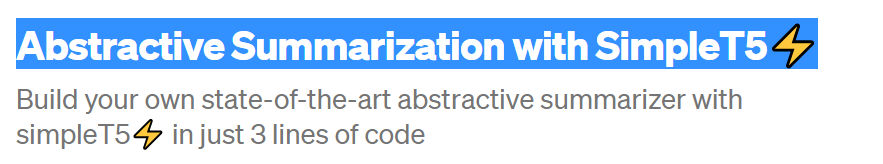

In [10]:
from simplet5 import SimpleT5
# instantiate
model = SimpleT5()

# load (supports t5, mt5, byT5 models)
model.from_pretrained(model_type='t5',model_name='t5-base')

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [12]:
# train
model.train(train_df=train_df, # pandas dataframe with 2 columns: source_text & target_text
            eval_df=test_df, # pandas dataframe with 2 columns: source_text & target_text
            source_max_token_len = 512, 
            target_max_token_len = 128,
            batch_size = 8,
            max_epochs = 5,
            use_gpu = True,
            outputdir = "outputs",
            early_stopping_patience_epochs = 0,
            precision = 32
            )

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

##Abstractive Summarization

In [17]:
# let's load the trained model for inferencing:
model.load_model("t5","outputs/simplet5-epoch-2-train-loss-0.921-val-loss-1.2816", use_gpu=False)

text_to_summarize="""summarize: Rahul Gandhi has replied to Goa CM Manohar Parrikar's letter, 
which accused the Congress President of using his "visit to an ailing man for political gains". 
"He's under immense pressure from the PM after our meeting and needs to demonstrate his loyalty by attacking me," 
Gandhi wrote in his letter. Parrikar had clarified he didn't discuss Rafale deal with Rahul.
"""
model.predict(text_to_summarize)

["Rahul Gandhi responds to Manohar Parrikar's letter accusing him"]

In [18]:
text_to_summarize ="""summarize: Ukrainian reports say Putin's troops are fleeing east to the Russian border in whatever transport they can find, even taking cars from the civilian population in the areas they had captured since the start of the war in February.
In their wake they leave hundreds of pieces of the Russian war machine, which since Putin's so-called "special military operation" commenced, has not come close to living up to its pre-war billing as one of the world's great powers.These Russian losses are the accumulation of a multitude of existing problems that are now colliding head-on with a Ukrainian military that has been patient, methodical and infused with billions of dollars of the Western military equipment that Russia cannot match."""

In [19]:
model.predict(text_to_summarize)

["Putin's troops fleeing east to Russian border: Reports"]

## T5 model with simpleT5 on entire ArXiv dataset to generate a one line summary of research articles 

In [20]:
# pip install --upgrade simplet5
from simplet5 import SimpleT5
abstract = """This interpretation has been recently questioned in a systematic study of the even mass isotopes of Mo, Ru, Pd, Cd, and Te [4]. The authors concluded that the existence of low-energy quadrupole vibrations in some of these nuclei must be questioned and that the study of collective states must involve not only electromagnetic observable such as B(E2) values and quadrupole moments, which by definition only sample the charge and/or current distributions, but also other electromagnetic probes that are sensitive to shape coexistence and configuration mixing, such as, for instance, the electric monopole (E0) transitions.
The question of whether Pd nuclei may actually exhibit a nearly-harmonic quadrupole structure has been recently addressed by two experiments involving the neutron inelastic scattering, devoted to the study of the structure of the 106Pd isotope [5, 6]. In the first one, a characterization of the low-lying excited states up to ≈2.4 MeV for spin ≤ 6 was obtained. The level scheme was organized into rotational bands, each characterized by adefinite value of K."""
model = SimpleT5()
model.load_model("t5","snrspeaks/t5-one-line-summary")
output = model.predict(abstract)

print(output)

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

['Low-lying excited states in the structure of the 106Pd isotope']


In [21]:
abstract ="""Nuclear magnetic resonance (NMR) spectroscopy is a powerful chemical characterization tool widely used in disciplines ranging from materials to biomedical sciences. However, it is limited by low sensitivity, typically requiring a substantial amount of material for analysis1. One promising way to overcome this limitation is via the use of nanoscale spin defects in solids, which can be brought in close contact with the sample2–6. The most promising system is the nitrogen vacancy (NV) center in diamond, which has been used to detect NMR signals from a few zeptoliters of material, single molecules or even nuclear spins under ambient conditions7,8. The NV-center (Fig. 1 A) is a spin defect in the lattice of a diamond. The spin quantum states of such defect centers can be optically prepared with green laser light, manipulated with microwave pulses and optically read-out by their spin-dependent photoluminescence (PL).9 Dynamic decoupling pulse sequences (such as XY8-N, where N is the number of π pulses ) can be used as a narrowband detection scheme for oscillating magnetic fields at frequency f = 1/(2τ), where τ is the temporal spacing between the microwave π pulses (Fig. 1 B). Sweeping the time tcorr between two XY8-N blocks correlates the magnetic signals from the nuclear spins, which can be detected as oscillations in the PL readout as a function of tcorr and resembles the free induction decay in traditional NMR spectroscopy"""
output = model.predict(abstract)
print(output)

['NMR spectroscopy of the nitrogen vacancy center in diamond']
